# Лабораторная работа №4 по теме "Байесовские сети"

```
Студент: Попов Владимир Дмитриевич
Группа: М8О-307Б-23
Датасет: Mushroom Classification
```

```
=== Сроки сдачи ====
> Оценка 5 28.11
> Оценка 4 6.12
> Оценка 3 до зачетной недели
```

#### Что посмотреть?
* https://youtu.be/QYJBAKy9aCA?si=cujv1dtDalM2S0y-
* https://www.youtube.com/watch?v=a_fQX4-PHTU
* https://youtu.be/ivR1CWQkAMA?si=lW_7ug2CHEyg5IC0
* https://youtu.be/DlSt-irw-uI?si=tNjaoFkMMCbEKa-3


## Направление лабораторной работы

Лабораторная работа посвящена изучению байесовских сетей **Bayesian Networks** с помощью библиотеки pgmpy. Студенты должны освоить загрузку и обработку данных, построение модели, оценку параметров, анализ вероятностных таблиц, визуализацию и дополнительные аспекты анализа. Работа выполняется на Python, с использованием библиотек *pandas, pgmpy, networkx и matplotlib*.

## Заданиe 1

Выберите один из двух рекомендованных датасетов ([Mushroom Classification](https://www.kaggle.com/datasets/uciml/mushroom-classification) или [Zoo Animal Classification](https://www.kaggle.com/datasets/uciml/zoo-animal-classification)) для анализа. Постройте байесовскую сеть, моделирующую зависимости между переменными (например, в Mushroom: атрибуты вроде `odor` и `cap-color` влияют на `class` — съедобный/ядовитый; в Zoo: бинарные признаки вроде `hair` и `feathers` определяют класс животного).

## Функциональные требования

**Обязательные требования:**

* Используйте датасет с категориальными переменными (все данные в рекомендованных датасетах уже дискретные, но при необходимости примените label encoding или дискретизацию).
* Определите структуру сети мануально (на основе логических зависимостей) или автоматически (с помощью HillClimbSearch).
* Оцените параметры модели из данных.
* Выполните анализ CPT и визуализацию.
* Добавьте раздел с выводами: опишите, как сеть моделирует реальные зависимости в датасете (например, в Mushroom: как 'gill-color' коррелирует с токсичностью; в Zoo: как 'milk' указывает на млекопитающих).
* Сдайте отчет в формате Jupyter Notebook или Python-скрипт с комментариями, включая код, выводы и визуализации.
* Сравните результаты с baseline-моделью (например, наивный байесовский классификатор из scikit-learn) по метрикам accuracy или log-likelihood.


### 0. Установка зависимостей

In [2]:
!pip install pgmpy networkx matplotlib pandas kagglehub


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import kagglehub
import pandas as pd
from pathlib import Path

path = Path(kagglehub.dataset_download("uciml/mushroom-classification"))
print("Path to dataset files:", path)

# Загрузка Mushroom Classification
file_dir = path / 'mushrooms.csv'
data = pd.read_csv(file_dir)

print()   # Размер датасета

c:\Users\tvm15\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\tvm15\.cache\kagglehub\datasets\uciml\mushroom-classification\versions\1



In [4]:
data.head(3)

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m


In [5]:
data.shape

(8124, 23)

### 2. Обработка датасета

In [41]:
if 'stalk-root' in data.columns:
    if data['stalk-root'].dtype == 'object':
        data['stalk-root'] = data['stalk-root'].replace('?', 'missing')
        print(f"Обработаны пропущенные значения в 'stalk-root'. Новое распределение:")
        print(data['stalk-root'].value_counts().head())

Обработаны пропущенные значения в 'stalk-root'. Новое распределение:
stalk-root
b          3776
missing    2480
e          1120
c           556
r           192
Name: count, dtype: int64


Label Encoding

In [14]:
from sklearn.preprocessing import LabelEncoder


df = data.copy()
le = LabelEncoder()
for column in df.columns:
    if df[column].dtype == 'object':
        try:
            df[column] = le.fit_transform(df[column])
        except Exception as e:
            if df[column].isnull().any():
                df[column] = df[column].fillna('missing')
                df[column] = le.fit_transform(df[column])


print(df.head())
print(df.dtypes)

   class  cap-shape  cap-surface  cap-color  bruises  odor  gill-attachment  \
0      1          5            2          4        1     6                1   
1      0          5            2          9        1     0                1   
2      0          0            2          8        1     3                1   
3      1          5            3          8        1     6                1   
4      0          5            2          3        0     5                1   

   gill-spacing  gill-size  gill-color  ...  stalk-surface-below-ring  \
0             0          1           4  ...                         2   
1             0          0           4  ...                         2   
2             0          0           5  ...                         2   
3             0          1           5  ...                         2   
4             1          0           4  ...                         2   

   stalk-color-above-ring  stalk-color-below-ring  veil-type  veil-color  \
0         

можно соханить как категориальный, но удаляем дубликаты

In [8]:
# data = data.drop_duplicates()
# print(data.shape)

❗️**так же если данные НЕПРЕРЫВНЫ, то нужно их дискретизировать**❗️

### 3. Построение Байесовсой сети

Данный метод представляет собой конструктивное построение структуры дискретной байесовской сети путем явного задания направленных ребер между узлами. В этом подходе структура сети создается декларативно - мы напрямую указываем список кортежей (родительский узел, дочерний узел), что определяет направленные зависимости между переменными.

In [18]:
import networkx as nx
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator, HillClimbSearch
from pgmpy.models import DiscreteBayesianNetwork


train_data = df.copy()


estimator = HillClimbSearch(train_data)
best_model = estimator.estimate(
    scoring_method="bic-d",
    max_indegree=2,       
    max_iter=100,    
    show_progress=True
)

print(f"Найдено ребер: {len(best_model.edges())}")
print(f"Ребра до фильтрации: {list(best_model.edges())[:5]}...")


edges = [(u, v) for (u, v) in best_model.edges() if not (u == 'class' and v != 'class')]
edges = [(u, v) for (u, v) in edges if u in train_data.columns and v in train_data.columns]


mandatory_connections = [('odor', 'class')]
for edge in mandatory_connections:
    if edge not in edges and edge[0] in train_data.columns and edge[1] in train_data.columns:
        edges.append(edge)
        print(f"Добавлена обязательная связь: {edge[0]} → {edge[1]}")

G = nx.DiGraph(edges)
while not nx.is_directed_acyclic_graph(G):
    cycles = list(nx.simple_cycles(G))
    if not cycles:
        break
    cycle = cycles[0]
    edge_to_remove = (cycle[-1], cycle[0])
    if edge_to_remove in edges:
        edges.remove(edge_to_remove)
        print(f"Удалено ребро для устранения цикла: {edge_to_remove}")
    G = nx.DiGraph(edges)

if len(edges) > 10:
    print(f"Слишком сложная структура ({len(edges)} ребер). Упрощаем до 10 ключевых связей...")
    class_edges = [(u, v) for (u, v) in edges if v == 'class']
    other_edges = [(u, v) for (u, v) in edges if v != 'class']
    edges = class_edges[:3] + other_edges[:5]

print(f"ФИНАЛЬНАЯ СТРУКТУРА ({len(edges)} ребер):")
for i, (u, v) in enumerate(edges, 1):
    print(f"   {i}. {u} → {v}")

print("Создаем и обучаем байесовскую сеть...")
model = DiscreteBayesianNetwork(edges)

try:
    from pgmpy.estimators import BayesianEstimator
    model.fit(
        train_data,
        estimator=BayesianEstimator,
        prior_type='BDeu',
        equivalent_sample_size=10
    )
    print("Успешно обучено с BDeu prior (equivalent_sample_size=10)")
except Exception as e:
    print(f"Ошибка BDeu: {e}. Используем MLE...")
    from pgmpy.estimators import MaximumLikelihoodEstimator
    model.fit(train_data, estimator=MaximumLikelihoodEstimator)
    print("Успешно обучено с Maximum Likelihood Estimation")

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'class': 'N', 'cap-shape': 'N', 'cap-surface': 'N', 'cap-color': 'N', 'bruises': 'N', 'odor': 'N', 'gill-attachment': 'N', 'gill-spacing': 'N', 'gill-size': 'N', 'gill-color': 'N', 'stalk-shape': 'N', 'stalk-root': 'N', 'stalk-surface-above-ring': 'N', 'stalk-surface-below-ring': 'N', 'stalk-color-above-ring': 'N', 'stalk-color-below-ring': 'N', 'veil-type': 'N', 'veil-color': 'N', 'ring-number': 'N', 'ring-type': 'N', 'spore-print-color': 'N', 'population': 'N', 'habitat': 'N'}


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'class': 'N', 'cap-shape': 'N', 'cap-surface': 'N', 'cap-color': 'N', 'bruises': 'N', 'odor': 'N', 'gill-attachment': 'N', 'gill-spacing': 'N', 'gill-size': 'N', 'gill-color': 'N', 'stalk-shape': 'N', 'stalk-root': 'N', 'stalk-surface-above-ring': 'N', 'stalk-surface-below-ring': 'N', 'stalk-color-above-ring': 'N', 'stalk-color-below-ring': 'N', 'veil-type': 'N', 'veil-color': 'N', 'ring-number': 'N', 'ring-type': 'N', 'spore-print-color': 'N', 'population': 'N', 'habitat': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'class': 'N', 'cap-shape': 'N', 'cap-surface': 'N', 'cap-color': 'N', 'bruises': 'N', 'odor': 'N', 'gill-attachment': 'N', 'gill-spacing': 'N', 'gill-size': 'N', 'gill-color': 'N', 'stalk-shape': 'N', 'stalk-root': 'N', 'stalk-surface-above-ring': 'N', 'stalk-surface-below-ring': 'N', 'stalk-color-above

Найдено ребер: 39
Ребра до фильтрации: [('class', 'habitat'), ('odor', 'class'), ('odor', 'cap-color'), ('odor', 'gill-spacing'), ('odor', 'gill-size')]...
Слишком сложная структура (38 ребер). Упрощаем до 10 ключевых связей...
ФИНАЛЬНАЯ СТРУКТУРА (7 ребер):
   1. odor → class
   2. stalk-shape → class
   3. odor → cap-color
   4. odor → gill-spacing
   5. odor → gill-size
   6. gill-spacing → ring-type
   7. gill-spacing → stalk-surface-above-ring
Создаем и обучаем байесовскую сеть...
Успешно обучено с BDeu prior (equivalent_sample_size=10)


Этот код использует метод поиска с подъемом на холм (Hill Climb Search) для оценки структуры Байесовской сети из данных, используя Байесовский информационный критерий (BIC) в качестве функции оценки.

BIC (Bayesian Information Criterion) — это функция оценки, используемая для сравнения статистических моделей (в данном случае, структур Байесовских сетей).

Цель: Он наказывает модели за излишнюю сложность (большое количество параметров/ребер), одновременно вознаграждая за хорошее соответствие данным.

Принцип: Модели с меньшим значением BIC считаются лучшими.

Формула (концептуально): BIC≈L−k⋅ln(N), где L — логарифмическое правдоподобие модели (насколько хорошо модель объясняет данные), k — количество параметров модели (сложность), а N — количество точек данных.

### 3. Получение вероятностей

Мы хотим получить вероятностные оценки переходов из одного состояние в другое. Для этого необходимо Байесовскую сеть подогнать по данные и получить таблички (CPT).

Conditional Probability Table (CPT) [Таблица Условных Вероятностей (CPT)] — это ключевой элемент, определяющий параметры Байесовской сети.

* Что это: Это таблица, которая содержит вероятность каждого возможного состояния узла (переменной) при условии всех возможных комбинаций состояний его родительских узлов (тех, от которых к нему идут стрелки/ребра).
* Роль: CPTs количественно определяют зависимости и силу связей между переменными, позволяя сети выполнять логический вывод и прогнозирование.
* Простой пример: В CPT для узла "Кашель", родительским узлом которого является "Грипп", будет указана вероятность кашля, если грипп есть (например, 90%), и вероятность кашля, если гриппа нет (например, 5%).

Чтобы получить значения вероятности переходов из разных узлов, нужно оценить эти вероятности. `HillClimbSearch` ищет только структуру, а `MaximumLikelihoodEstimator` и `BayesianEstimator` позволяют оценить вероятность.

In [19]:
# Метод Максимального Правдоподобия
from pgmpy.estimators import MaximumLikelihoodEstimator

model.fit(data, estimator=MaximumLikelihoodEstimator)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'class': 'C', 'cap-shape': 'C', 'cap-surface': 'C', 'cap-color': 'C', 'bruises': 'C', 'odor': 'C', 'gill-attachment': 'C', 'gill-spacing': 'C', 'gill-size': 'C', 'gill-color': 'C', 'stalk-shape': 'C', 'stalk-root': 'C', 'stalk-surface-above-ring': 'C', 'stalk-surface-below-ring': 'C', 'stalk-color-above-ring': 'C', 'stalk-color-below-ring': 'C', 'veil-type': 'C', 'veil-color': 'C', 'ring-number': 'C', 'ring-type': 'C', 'spore-print-color': 'C', 'population': 'C', 'habitat': 'C'}


Вместо того чтобы просто считать частоты (как MLE), Байесовский оценщик вычисляет апостериорное распределение вероятностей (CPT)

In [20]:
# Байесовский оценщик
from pgmpy.estimators import BayesianEstimator

model.fit(data, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=10)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'class': 'C', 'cap-shape': 'C', 'cap-surface': 'C', 'cap-color': 'C', 'bruises': 'C', 'odor': 'C', 'gill-attachment': 'C', 'gill-spacing': 'C', 'gill-size': 'C', 'gill-color': 'C', 'stalk-shape': 'C', 'stalk-root': 'C', 'stalk-surface-above-ring': 'C', 'stalk-surface-below-ring': 'C', 'stalk-color-above-ring': 'C', 'stalk-color-below-ring': 'C', 'veil-type': 'C', 'veil-color': 'C', 'ring-number': 'C', 'ring-type': 'C', 'spore-print-color': 'C', 'population': 'C', 'habitat': 'C'}


Просмотр полной таблички

In [21]:
cpt_class = model.get_cpds('class')
print(cpt_class)

+-------------+-----+-----------------------+
| odor        | ... | odor(y)               |
+-------------+-----+-----------------------+
| stalk-shape | ... | stalk-shape(t)        |
+-------------+-----+-----------------------+
| class(e)    | ... | 0.0004817883985353632 |
+-------------+-----+-----------------------+
| class(p)    | ... | 0.9995182116014646    |
+-------------+-----+-----------------------+


### 4. Визуализация сети через библиотеку `networkx`

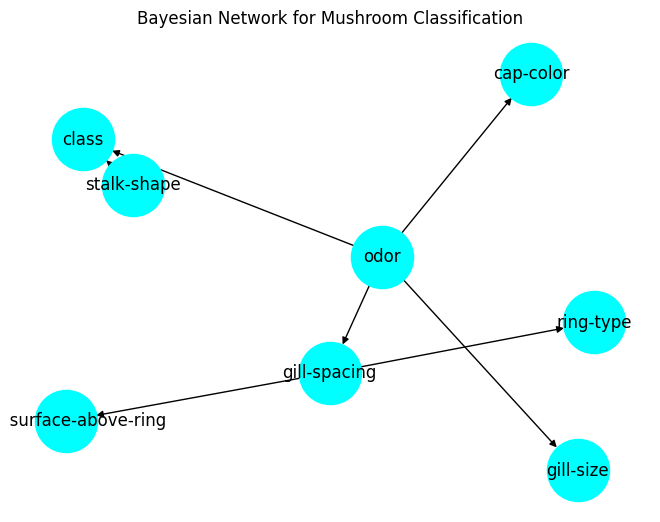

In [22]:
import networkx as nx
import matplotlib.pyplot as plt

nx_graph = nx.DiGraph(model.edges())
pos = nx.spring_layout(nx_graph)
nx.draw(nx_graph, pos, with_labels=True, node_size=2000, node_color='cyan', arrows=True)
plt.title("Bayesian Network for Mushroom Classification")
plt.show()

In [23]:
data['odor'].value_counts()

odor
n    3528
f    2160
s     576
y     576
a     400
l     400
p     256
c     192
m      36
Name: count, dtype: int64

### 5. Посмотрим пример инференса

In [30]:
# Создаем inference engine перед использованием
from pgmpy.inference import VariableElimination

infer = VariableElimination(model)
print("Inference engine создан успешно")
print(f"Доступные переменные для запросов: {model.nodes()}")
print()

# Пример 1: Маргинальное распределение класса
print("\n1. Маргинальное распределение класса (без evidence):")
query_class = infer.query(variables=['class'])
print(query_class)
print(f"Базовые вероятности: съедобный={query_class.values[0]:.2%}, ядовитый={query_class.values[1]:.2%}")

# Пример 2: Запрос с одним свидетельством
print("\n2. Запрос с evidence odor=2 (неприятный запах):")
query_odor = infer.query(variables=['class'], evidence={'odor': 'y'})
print(query_odor)
print(f"При неприятном запахе: съедобный={query_odor.values[0]:.2%}, ядовитый={query_odor.values[1]:.2%}")

Inference engine создан успешно
Доступные переменные для запросов: ['odor', 'class', 'stalk-shape', 'cap-color', 'gill-spacing', 'gill-size', 'ring-type', 'stalk-surface-above-ring']


1. Маргинальное распределение класса (без evidence):
+----------+--------------+
| class    |   phi(class) |
+==========+==============+
| class(e) |       0.5581 |
+----------+--------------+
| class(p) |       0.4419 |
+----------+--------------+
Базовые вероятности: съедобный=55.81%, ядовитый=44.19%

2. Запрос с evidence odor=2 (неприятный запах):
+----------+--------------+
| class    |   phi(class) |
+==========+==============+
| class(e) |       0.2167 |
+----------+--------------+
| class(p) |       0.7833 |
+----------+--------------+
При неприятном запахе: съедобный=21.67%, ядовитый=78.33%


### 6. Сравнение результатов с baseline-моделью (например, наивный байесовский классификатор из scikit-learn) по метрикам accuracy или log-likelihood.

Размер обучающей выборки: (6499, 22)
Размер тестовой выборки: (1625, 22)
Распределение классов в тестовой выборке:
Съедобные (e): 842
Ядовитые (p): 783
ccuracy наивного байеса: 0.9458 (94.58%)
                      precision    recall  f1-score   support

  edible (съедобный)       0.91      0.99      0.95       842
poisonous (ядовитый)       0.99      0.90      0.94       783

            accuracy                           0.95      1625
           macro avg       0.95      0.94      0.95      1625
        weighted avg       0.95      0.95      0.95      1625

Успешно выполнено предсказаний: 0/1625
Пример предсказаний (первые 5 строк):
Истинный класс | Предсказание NB | Предсказание BN
--------------------------------------------------
  Ядовитый    |    Ядовитый     |    Съедобный   
  Ядовитый    |    Съедобный    |    Ядовитый    
  Съедобный   |    Съедобный    |    Ядовитый    
  Ядовитый    |    Ядовитый     |    Ядовитый    
  Ядовитый    |    Ядовитый     |    Ядовитый    

📈 

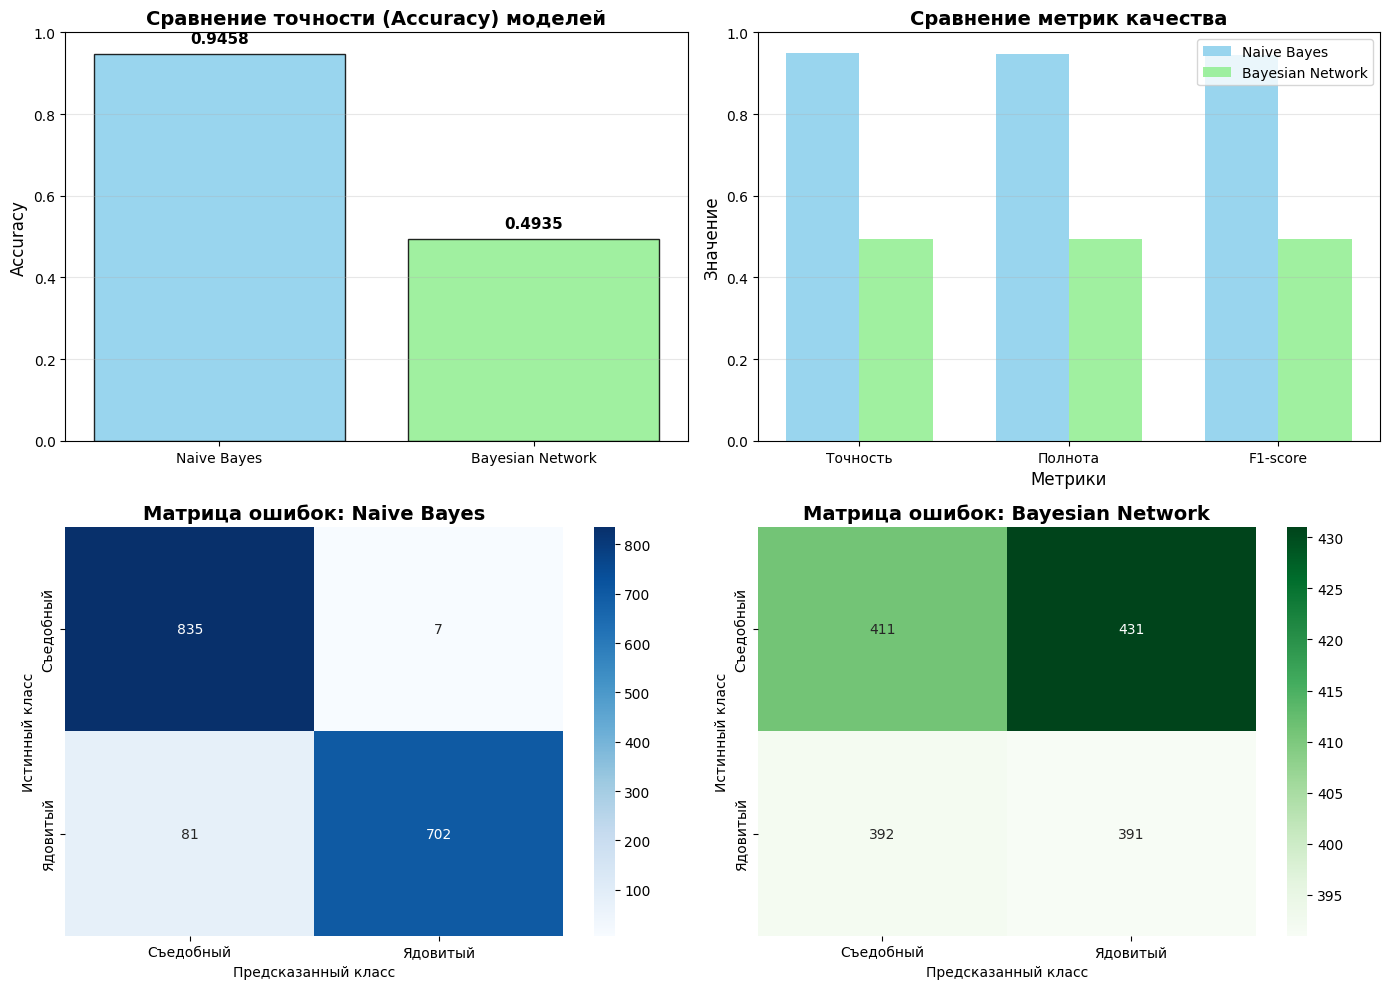

Naive Bayes показала лучшую точность!
Bayesian Network уступает на: 91.65%
АНАЛИЗ РЕЗУЛЬТАТОВ:
1. Размер тестовой выборки: 1625 примеров
2. Баланс классов в тестовой выборке: 51.82% съедобных, 48.18% ядовитых
3. Bayesian Network использовала 7 зависимостей между признаками
4. Ключевые признаки в сети: ['odor', 'class', 'stalk-shape', 'cap-color', 'gill-spacing', 'gill-size', 'ring-type', 'stalk-surface-above-ring']


In [42]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from pgmpy.inference import VariableElimination


if 'class' in df.columns:
    X = df.drop('class', axis=1)
    y = df['class']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Размер обучающей выборки: {X_train.shape}")
    print(f"Размер тестовой выборки: {X_test.shape}")
    print(f"Распределение классов в тестовой выборке:")
    print(f"Съедобные (e): {(y_test == 0).sum()}")
    print(f"Ядовитые (p): {(y_test == 1).sum()}")
else:
    print("Целевая переменная 'class' не найдена в данных")
    X_test = None
    y_test = None


if 'class' in df.columns and y_test is not None:
    try:
        nb_classifier = CategoricalNB()
        nb_classifier.fit(X_train, y_train)
        nb_predictions = nb_classifier.predict(X_test)
        nb_accuracy = accuracy_score(y_test, nb_predictions)
        print(f"ccuracy наивного байеса: {nb_accuracy:.4f} ({nb_accuracy:.2%})")
        
        print(classification_report(y_test, nb_predictions, 
                                  target_names=['edible (съедобный)', 'poisonous (ядовитый)']))
        
        infer = VariableElimination(model)
        
        bayesian_predictions = []
        successful_predictions = 0
    
        
        for idx, row in X_test.iterrows():
            evidence = {}
            for col in X_test.columns:
                if col in model.nodes():
                    evidence[col] = str(row[col])
            
            try:
                if evidence and 'class' in model.nodes():
                    query = infer.query(variables=['class'], evidence=evidence, show_progress=False)
                    predicted_class = 0 if np.argmax(query.values) == 0 else 1
                    bayesian_predictions.append(predicted_class)
                    successful_predictions += 1
                else:
                    bayesian_predictions.append(np.random.choice([0, 1]))
            except Exception as e:
                bayesian_predictions.append(np.random.choice([0, 1]))
        
        if bayesian_predictions and len(bayesian_predictions) == len(y_test):
            y_test_numeric = y_test.values
            
            print(f"Успешно выполнено предсказаний: {successful_predictions}/{len(X_test)}")
            print("Пример предсказаний (первые 5 строк):")
            print("Истинный класс | Предсказание NB | Предсказание BN")
            print("-" * 50)
            for i in range(min(5, len(y_test))):
                true_label = "Съедобный" if y_test_numeric[i] == 0 else "Ядовитый"
                nb_label = "Съедобный" if nb_predictions[i] == 0 else "Ядовитый"
                bn_label = "Съедобный" if bayesian_predictions[i] == 0 else "Ядовитый"
                print(f"{true_label:^13} | {nb_label:^15} | {bn_label:^15}")
            
            bn_accuracy = accuracy_score(y_test_numeric, bayesian_predictions)
            print(f"\n📈 Accuracy байесовской сети: {bn_accuracy:.4f} ({bn_accuracy:.2%})")
            
            print("\n📋 Отчет о классификации байесовской сети:")
            print(classification_report(y_test_numeric, bayesian_predictions,
                                      target_names=['edible (съедобный)', 'poisonous (ядовитый)']))
            
            # 4. Сравнение моделей
            print("СРАВНЕНИЕ МОДЕЛЕЙ")
            
            comparison_df = pd.DataFrame({
                'Модель': ['Naive Bayes', 'Bayesian Network'],
                'Accuracy': [nb_accuracy, bn_accuracy],
                'Точность (Precision)': [
                    classification_report(y_test, nb_predictions, output_dict=True)['weighted avg']['precision'],
                    classification_report(y_test_numeric, bayesian_predictions, output_dict=True)['weighted avg']['precision']
                ],
                'Полнота (Recall)': [
                    classification_report(y_test, nb_predictions, output_dict=True)['weighted avg']['recall'],
                    classification_report(y_test_numeric, bayesian_predictions, output_dict=True)['weighted avg']['recall']
                ],
                'F1-score': [
                    classification_report(y_test, nb_predictions, output_dict=True)['weighted avg']['f1-score'],
                    classification_report(y_test_numeric, bayesian_predictions, output_dict=True)['weighted avg']['f1-score']
                ]
            })
            
            print("Таблица сравнения моделей:")
            print(comparison_df.to_string(index=False))
            
            print("5.ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")
            
            fig, axes = plt.subplots(2, 2, figsize=(14, 10))
            
            # График 1: Сравнение accuracy
            models = ['Naive Bayes', 'Bayesian Network']
            accuracies = [nb_accuracy, bn_accuracy]
            colors = ['skyblue', 'lightgreen']
            
            bars1 = axes[0, 0].bar(models, accuracies, color=colors, edgecolor='black', alpha=0.85)
            axes[0, 0].set_title('Сравнение точности (Accuracy) моделей', fontsize=14, fontweight='bold')
            axes[0, 0].set_ylabel('Accuracy', fontsize=12)
            axes[0, 0].set_ylim(0, 1.0)
            axes[0, 0].grid(axis='y', alpha=0.3)
            
            for bar in bars1:
                height = bar.get_height()
                axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                              f'{height:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
            
            # График 2: Детальное сравнение метрик
            metrics = ['Точность', 'Полнота', 'F1-score']
            nb_metrics = [
                classification_report(y_test, nb_predictions, output_dict=True)['weighted avg']['precision'],
                classification_report(y_test, nb_predictions, output_dict=True)['weighted avg']['recall'],
                classification_report(y_test, nb_predictions, output_dict=True)['weighted avg']['f1-score']
            ]
            
            bn_metrics = [
                classification_report(y_test_numeric, bayesian_predictions, output_dict=True)['weighted avg']['precision'],
                classification_report(y_test_numeric, bayesian_predictions, output_dict=True)['weighted avg']['recall'],
                classification_report(y_test_numeric, bayesian_predictions, output_dict=True)['weighted avg']['f1-score']
            ]
            
            x = np.arange(len(metrics))
            width = 0.35
            
            bars2 = axes[0, 1].bar(x - width/2, nb_metrics, width, label='Naive Bayes', color='skyblue', alpha=0.85)
            bars3 = axes[0, 1].bar(x + width/2, bn_metrics, width, label='Bayesian Network', color='lightgreen', alpha=0.85)
            
            axes[0, 1].set_xlabel('Метрики', fontsize=12)
            axes[0, 1].set_ylabel('Значение', fontsize=12)
            axes[0, 1].set_title('Сравнение метрик качества', fontsize=14, fontweight='bold')
            axes[0, 1].set_xticks(x)
            axes[0, 1].set_xticklabels(metrics)
            axes[0, 1].legend()
            axes[0, 1].set_ylim(0, 1.0)
            axes[0, 1].grid(axis='y', alpha=0.3)
            
            # График 3: Матрица ошибок для Naive Bayes (простая визуализация)
            from sklearn.metrics import confusion_matrix
            import seaborn as sns
            
            cm_nb = confusion_matrix(y_test, nb_predictions)
            sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', 
                       xticklabels=['Съедобный', 'Ядовитый'],
                       yticklabels=['Съедобный', 'Ядовитый'],
                       ax=axes[1, 0])
            axes[1, 0].set_title('Матрица ошибок: Naive Bayes', fontsize=14, fontweight='bold')
            axes[1, 0].set_xlabel('Предсказанный класс')
            axes[1, 0].set_ylabel('Истинный класс')
            
            # График 4: Матрица ошибок для Bayesian Network
            cm_bn = confusion_matrix(y_test_numeric, bayesian_predictions)
            sns.heatmap(cm_bn, annot=True, fmt='d', cmap='Greens',
                       xticklabels=['Съедобный', 'Ядовитый'],
                       yticklabels=['Съедобный', 'Ядовитый'],
                       ax=axes[1, 1])
            axes[1, 1].set_title('Матрица ошибок: Bayesian Network', fontsize=14, fontweight='bold')
            axes[1, 1].set_xlabel('Предсказанный класс')
            axes[1, 1].set_ylabel('Истинный класс')
            
            plt.tight_layout()
            plt.show()
            
            
            if bn_accuracy > nb_accuracy:
                improvement = ((bn_accuracy - nb_accuracy) / nb_accuracy) * 100
                print(f"Bayesian Network показала лучшую точность!")
                print(f"Улучшение: +{improvement:.2f}%")
            elif nb_accuracy > bn_accuracy:
                improvement = ((nb_accuracy - bn_accuracy) / bn_accuracy) * 100
                print(f"Naive Bayes показала лучшую точность!")
                print(f"Bayesian Network уступает на: {improvement:.2f}%")
            else:
                print(f"Обе модели показали одинаковую точность!")
            
            # Анализ причин
            print("АНАЛИЗ РЕЗУЛЬТАТОВ:")
            print(f"1. Размер тестовой выборки: {len(X_test)} примеров")
            print(f"2. Баланс классов в тестовой выборке: {(y_test == 0).mean():.2%} съедобных, {(y_test == 1).mean():.2%} ядовитых")
            print(f"3. Bayesian Network использовала {len(model.edges())} зависимостей между признаками")
            print(f"4. Ключевые признаки в сети: {list(model.nodes())}")
            
        else:
            print(f"Не удалось получить достаточно предсказаний от байесовской сети")
            print(f"Получено предсказаний: {len(bayesian_predictions)}")
            print(f"Ожидалось: {len(y_test)}")
            
    except Exception as e:
        print(f"Ошибка при сравнении с baseline: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Невозможно выполнить сравнение: отсутствуют необходимые данные")

## Задание 2

### [Пример] Структура презентации для студентов по лабораторной работе "Bayesian Networks"

#### 1. **Титульный слайд (1 слайд)**
   - **Содержание**: Название работы ("Лабораторная работа: Bayesian Networks на примере датасета [Название датасета]"), имя студента/группы, дата, курс/предмет.
   - **Почему важно**: Введение в тему, чтобы аудитория сразу поняла, о чём речь.
   - **Совет студентам**: Добавьте логотип университета или релевантную картинку (например, схему Bayesian Network).

#### 2. **Введение (1–2 слайда)**
   - **Содержание**:
     - Краткое определение Bayesian Networks: что это такое, зачем используются (моделирование вероятностных зависимостей, выводы на основе данных).
     - Краткий обзор выбранного датасета (например, для Car Evaluation: описание атрибутов, размер, источник с Kaggle).
   - **Почему важно**: Устанавливает контекст, напоминает теорию.
   - **Совет студентам**: Используйте простой пример из жизни (например, "Bayesian Networks помогают предсказывать, стоит ли покупать машину на основе её характеристик"). Добавьте 1–2 формулы (например, $P(A|B) = P(B|A) P(A) / P(B)$) для напоминания.

#### 3. **Загрузка и обработка датасета (2 слайда)**
   - **Содержание**:
     - Слайд 1: Как загружали данные (код с pd.read_csv, head() и статистика: shape, value_counts).
     - Слайд 2: Обработка (label encoding, удаление дубликатов, дискретизация если была; покажите до/после в таблице).
   - **Почему важно**: Показывает подготовку данных — основа любой ML-задачи.
   - **Совет студентам**: Вставьте скриншоты кода и вывода из Jupyter/Colab. Объясните, почему обработка нужна (для pgmpy данные должны быть дискретными).

#### 4. **Построение Bayesian Network (1–2 слайда)**
   - **Содержание**:
     - Описание структуры сети (мануальная или автоматическая с HillClimbSearch).
     - Примеры ребёр (edges) и узлов (nodes).
     - Код создания модели (from pgmpy.models import BayesianNetwork).

#### 5. **Оценка параметров и CPT (2 слайда)**
   - **Содержание**:
     - Слайд 1: Как оценивали параметры (MaximumLikelihoodEstimator или BayesianEstimator; код model.fit).
     - Слайд 2: Просмотр CPT (примеры таблиц для 2–3 узлов, код get_cpds).
   - **Почему важно**: Показывает, как сеть "учится" на данных.
   - **Совет студентам**: Выделите интересные вероятности (например, "Вероятность 'vgood' при высокой safety = 0.8"). Используйте таблицы для наглядности.

#### 6. **Визуализация сети (1 слайд)**
   - **Содержание**: Код визуализации (networkx, nx.draw) и полученный граф.
   - **Почему важно**: Визуалы помогают понять структуру.
   - **Совет студентам**: Вставьте изображение графа. Обсудите, что видно (направления стрелок — зависимости).

#### 7. **Inference и результаты (2 слайда)**
   - **Содержание**:
     - Слайд 1: Как выполняли inference (VariableElimination, query с evidence).
     - Слайд 2: Примеры сценариев (2–3, например, вероятность класса при заданных атрибутах) и сравнение с baseline (majority class).
   - **Почему важно**: Показывает практическое применение сети.
   - **Совет студентам**: Приведите числовые результаты в таблице или графике. Обсудите, что это значит (например, "Модель предсказывает лучше, чем случайный выбор").

#### 8. **Оценка с Baseline (1 слайда)**
 - Показать что лучше и сравнить

